# Colour - HDRI - Example: Merge from Raw Files with Post Demosaicing

Through this example, some Canon EOS 5D Mark II *CR2* files will be merged together in order to create a single radiance image.

The following steps will be taken:

- Conversion of the *CR2* files to *DNG* files using [Adobe DNG Converter](http://www.adobe.com/support/downloads/detail.jsp?ftpID=5957).
- Conversion of the *DNG* files to intermediate non demosaiced linear *Tiff* files with Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- Reading of the *DNG* files *Exif* data with Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
- Reading of the intermediate *Tiff* files pixel data using [OpenImageIO](http://openimageio.org/).
- Merging to single radiance image.
- Demosaicing of the radiance image.
- Display of the final resulting radiance image.

Some steps can be performed using alternative methods or simplified, for instance the *DNG* conversion can be entirely avoided. Our interest here is to retrieve the camera levels and the [Adobe DNG](https://helpx.adobe.com/photoshop/digital-negative.html) camera colour profiling data.

## CR2 Files Conversion to DNG and Intermediate Files

In [1]:
% matplotlib inline

In [2]:
import logging
import matplotlib.pyplot
import matplotlib.gridspec
import numpy as np
import os

import colour
from colour.plotting import *
from colour_demosaicing import demosaicing_CFA_Bayer_DDFAPD

from colour_hdri.image import Image, ImageStack, Metadata
from colour_hdri.exif import update_exif_data, get_value
from colour_hdri.process import (
    convert_raw_files_to_dng_files,
    convert_dng_files_to_intermediate_files)
from colour_hdri.radiance import radiance_image
from colour_hdri.utilities import filter_files, linear_conversion
from colour_hdri.weighting_functions import weighting_function_Debevec1997

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

RESOURCES_DIRECTORY = os.path.join(os.getcwd(), 'resources')

In [3]:
RAW_FILES = filter_files(RESOURCES_DIRECTORY, ('CR2',))

DNG_FILES = convert_raw_files_to_dng_files(RAW_FILES, RESOURCES_DIRECTORY)
    
INTERMEDIATE_FILES = convert_dng_files_to_intermediate_files(
    DNG_FILES, RESOURCES_DIRECTORY, demosaicing=False)

update_exif_data(zip(DNG_FILES, INTERMEDIATE_FILES))

INFO:colour_hdri.process:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.dng" file.
INFO:colour_hdri.process:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.dng" file.
INFO:colour_hdri.process:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.dng" file.
INFO:colour_hdri.process:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.CR2" file to "/Users/kelsolaar/Docu

1

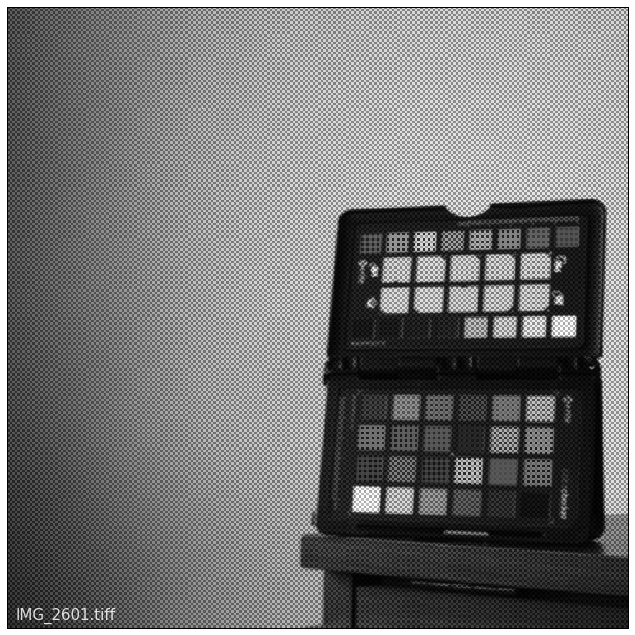

True

In [4]:
image_plot(OECF(colour.read_image(str(INTERMEDIATE_FILES[-2]))[1250:2250, 3000:4000, ...]),
           os.path.basename(INTERMEDIATE_FILES[-2]))

## Merging to Single Radiance Image and Demosaicing

In [5]:
def example_merge_from_raw_files_with_post_demosaicing(
    dng_files, 
    output_directory,
    batch_size=9, 
    weight_function=weighting_function_Debevec1997):

    for dng_files in colour.batch(dng_files, batch_size):
        image_stack = ImageStack()
        for dng_file in dng_files:
            image = Image(dng_file)
            image.read_metadata()
            image.path = str(dng_file.replace('dng', 'tiff'))
            image.read_data()            
            image_stack.append(image)

        LOGGER.info('Image stack "F Number": {0}'.format(image_stack.f_number))
        LOGGER.info('Image stack "Exposure Time": {0}'.format(image_stack.exposure_time))
        LOGGER.info('Image stack "ISO": {0}'.format(image_stack.iso))     
        
        LOGGER.info('Scaling "{}"...'.format(', '.join(
            image_stack.path)))
        LOGGER.info('\tBlack Level (Exif)    : {}'.format(
            image_stack.black_level[0]))
        LOGGER.info('\tWhite Level (Exif)    : {}'.format(
            image_stack.white_level[0]))

        black_level = (0 if 
                       image_stack.black_level[0] is None else 
                       np.average(image_stack.black_level[0]))

        # We are assuming that a least one image in the stack will have
        # saturated channels.
        white_level = np.max(image_stack.data)

        LOGGER.info('\tBlack Level (Analytic): {}'.format(
            black_level))
        LOGGER.info('\tWhite Level (Analytic): {}'.format(
            white_level))

        image_stack.data = linear_conversion(
            image_stack.data, (black_level, white_level), (0, 1))

        path = os.path.join(
            output_directory,
            '{0}_{1}.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))

        LOGGER.info('Merging "{0}"...'.format(path))
        image = radiance_image(image_stack, weight_function)
        
        image[np.isnan(image)] = 0

        LOGGER.info('Demosaicing "{0}"...'.format(path))
        image = demosaicing_CFA_Bayer_DDFAPD(image)
        
        LOGGER.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)
        
        return image, path

IMAGE, PATH = example_merge_from_raw_files_with_post_demosaicing(DNG_FILES, RESOURCES_DIRECTORY)

INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.dng" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.dng' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.tiff" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.dng" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.dng' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.tiff" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Devel

## Conversion from Camera Space to sRGB Colourspace

INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.dng' file 'ColorMatrix2' exif tag value: '0.4716 0.0603 -0.083 -0.7798 1.5474 0.248 -0.1496 0.1937 0.6651'
/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour/models/dataset/srgb.py:111: RuntimeWarning: invalid value encountered in power
  1.055 * (value ** (1 / 2.4)) - 0.055)


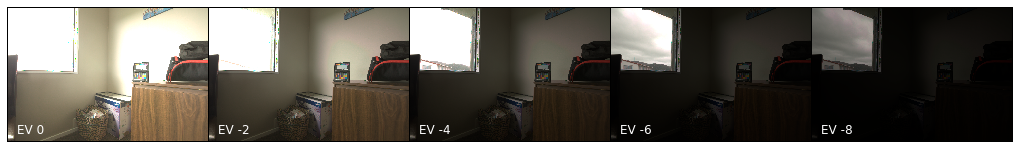

In [6]:
XYZ_TO_CAMERA_MATRIX = np.asarray(
    map(float, get_value(DNG_FILES[-2],
                         'ColorMatrix2').split())).reshape((3, 3))


def radiance_image_strip_plot(image, count=5):
    image = np.asarray(image)

    figure = matplotlib.pyplot.figure()

    grid = matplotlib.gridspec.GridSpec(1, count)
    grid.update(wspace=0, hspace=0)

    height, width, channel = image.shape
    for i in range(count):
        EV = -i * 2
        axis = matplotlib.pyplot.subplot(grid[i])
        axis.imshow(np.clip(OECF(image * pow(2, EV)), 0, 1))
        axis.text(width * 0.05,
                  height - height * 0.05,
                  'EV {0}'.format(EV),
                  color=(1, 1, 1))
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_aspect('equal')

    matplotlib.pyplot.show()


def camera_space_to_sRGB(RGB, xyz_to_camera_matrix=XYZ_TO_CAMERA_MATRIX):
    XYZ = colour.dot_vector(
        np.linalg.inv(XYZ_TO_CAMERA_MATRIX), RGB)

    sRGB = colour.XYZ_to_sRGB(XYZ,
                              colour.ILLUMINANTS['cie_2_1931']['D50'],
                              transfer_function=False)
    return sRGB


IMAGE_sRGB = camera_space_to_sRGB(IMAGE)

colour.write_image(IMAGE_sRGB, PATH.replace('.exr', '_RGB.exr'))

radiance_image_strip_plot(IMAGE_sRGB)